# Opening a food and supply store for dogs in Manhattan
## IBM Applied Data Science Capstone Project

## Table of contents
* [Introduction](#intro)
    * [Business problem](#business)
    * [Target stakeholders](#target)
* [Import python libraries](#libraries)
* [Data](#data)
    * [Import data](#dataimp)
    * [Information extraction from data](#info)
    * [Venue data from Foursquare APIs](#venue)
* [Clustering zip code areas in Manhattan](#clust)
* [Data analysis](#dataan)

## Introduction <a name="intro"></a>

## Business problem <a name="business"></a>
According to a study conducted by SmartAsset, New York City is among the 25 most pet friendly cities in America [5] with 8.5 million residents and more than 600,000 dogs. For this reason, opening a food and supply store for dogs would be a profitable business as well as a service very appreciated by the residents who owe a dog. However, the location of the store need to be chosen accurately as it is the key factor in the success of the business. In this project, I combine Foursquare APIs location data and machine learning to help the stakeholders make decisions by answering the following business questions: <br>
1) Which are the best neighbourhoods to live with a pet dog in Manhattan? <br>
2) Where should an entrepreneur open a food and supply store for dogs in Manhattan?<br>

## Target stakeholders <a name="target"></a>
Since the pet industry is one of the most stable and recession-resistant industries, this project is of interest for all those dog-lover entrepreneurs seeking to open a successful business during the COVID-19 pandemic. The outcome from this project is also relevant for dog owners moving to Manhattan who are interested in finding the best neighbourhood to live with their furry-friends. 


## 1 - Import python libraries <a name="libraries"></a>

In [1]:
# import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.exc import GeocoderTimedOut

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

# to get enough time gap to send requests to server 
from time import sleep

#!conda install -c conda-forge shapely 
import shapely.geometry

# !conda install -c conda-forge pyproj 
from pyproj import Transformer

import math

print('Libraries imported.')

Libraries imported.


## 2 - Data <a name="data"></a>
## 2.1 - Import data <a name="dataimp"></a>

I have found the list of the zip codes and corresponding neighborhood names in Manhattan from https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm . I have saved this data in a .csv file and here below I import them and display the first 10 rows.

In [2]:
df_zipcodes = pd.read_csv('Neighborhood_Zipcode.csv' ,engine='python')
print(df_zipcodes.shape)
df_zipcodes.head(10)

(43, 2)


,Neighborhood,Zip_Code
0,Central Harlem,10026
1,Central Harlem,10027
2,Central Harlem,10030
3,Central Harlem,10037
4,Central Harlem,10039
5,"Chelsea, Clinton",10001
6,"Chelsea, Clinton",10011
7,"Chelsea, Clinton",10018
8,"Chelsea, Clinton",10019
9,"Chelsea, Clinton",10020


I then import the public dataset (https://data.cityofnewyork.us/Health/NYC-Dog-Licensing-Dataset/nu7n-tubp) containing the licensed dogs in New York City. I display the first 5 rows.

In [3]:
df_dog = pd.read_csv('NYC_Dog_Licensing_Dataset.csv' ,engine='python')
df_dog = df_dog.rename(columns={'ZipCode': 'Zip_Code'})
print(df_dog.shape)
df_dog.head()

(345727, 10)


,RowNumber,AnimalName,AnimalGender,AnimalBirthMonth,BreedName,Borough,Zip_Code,LicenseIssuedDate,LicenseExpiredDate,Extract Year
0,1,PAIGE,F,2014,American Pit Bull Mix / Pit Bull Mix,NaN,10035,09/12/2014,09/12/2017,2016
1,2,YOGI,M,2010,Boxer,NaN,10465,09/12/2014,10/02/2017,2016
2,3,ALI,M,2014,Basenji,NaN,10013,09/12/2014,09/12/2019,2016
3,4,QUEEN,F,2013,Akita Crossbreed,NaN,10013,09/12/2014,09/12/2017,2016
4,5,LOLA,F,2009,Maltese,NaN,10028,09/12/2014,10/09/2017,2016


## 2.2 -  Information extraction from data <a name="info"></a>

Using the library pgeocode, I obtain the latitude and longitude of each zip code area in Manhattan. I display then the first 5 rows.

In [4]:
latlongzip=[]
import pgeocode
nomi = pgeocode.Nominatim('us')
for index, row in df_zipcodes.iterrows():
    postal_code = row['Zip_Code']
    location = nomi.query_postal_code(postal_code)
    latlongzip.append((location.latitude,location.longitude))


df_latlongzip = pd.DataFrame(latlongzip, columns=['Latitude','Longitude'])
df_latlongzip.head()
manhattan_data = pd.concat([df_zipcodes, df_latlongzip], axis=1, sort=False)
manhattan_data.head()

,Neighborhood,Zip_Code,Latitude,Longitude
0,Central Harlem,10026,40.8019,-73.9531
1,Central Harlem,10027,40.8116,-73.9550
2,Central Harlem,10030,40.8183,-73.9426
3,Central Harlem,10037,40.8135,-73.9381
4,Central Harlem,10039,40.8265,-73.9383


I show below the locations of the different zip code areas in Manhattan using Folium. The locations are indicated by a circle with a radius of 500 m. These areas will be used later on to explore the venues of interest using Foursquare APIs.

In [5]:
address = 'Harlem, New York City'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng in zip(manhattan_data['Latitude'], manhattan_data['Longitude']):
    folium.Circle(
        [lat, lng],
        radius=500,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

I have downloaded the geojson file from https://jsspina.carto.com/tables/nyc_zip_code_tabulation_areas_polygons/public/map containing the geometry of the polygons that delimit each zip code area in New York City. Below, I select only the polygons in Manhattan and save the information in a dataframe. I then dispaly the first 5 rows.

In [6]:
datajson=[]
with open("nyc_zip_code_tabulation_areas_polygons.geojson") as f:
    data = json.load(f)
    for i in range(len(data["features"])): 
        if data["features"][i]["properties"]['borough']=='Manhattan':
            zipcode = int(data["features"][i]["properties"]['postalcode'])
            polyid = int(data["features"][i]["properties"]['cartodb_id'])
            polycoord= data["features"][i]["geometry"]
            datajson.append((polyid,zipcode,polycoord))

df_nycpolygons = pd.DataFrame(datajson, columns=['Polygon ID','Zip_Code','Polygon coordinates'])
df_nycpolygons.head()

,Polygon ID,Zip_Code,Polygon coordinates
0,48,10463,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
1,51,10033,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
2,74,10037,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
3,77,10026,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."
4,229,10119,"{'type': 'MultiPolygon', 'coordinates': [[[[-7..."


I display below the polygons that delimit the zip code areas of Manhattan.

In [8]:
map_polygons = folium.Map(location=[latitude, longitude], zoom_start=10.5)

for index, row in df_nycpolygons.iterrows():
    folium.GeoJson(
        row['Polygon coordinates'],
        name='geojson',
        style_function=lambda x:{
            'fillColor': 'blue', 
            'color': 'black', 
            'weight': 1.5, 
            'fillOpacity': 0.5 },
    ).add_to(map_polygons)

map_polygons

I then compute the total number of dogs living in each zip code area. I save this information in a dataframe and merge it with  the other information of each zip code area. I display then first 5 rows.

In [9]:
df2=df_dog.groupby(df_dog['Zip_Code']).size().reset_index().rename(columns={0:'Dog count'})
df_dogcount = manhattan_data.merge(df2, how='inner', left_on=['Zip_Code'], right_on=['Zip_Code'])
df_dogcount.head()

,Neighborhood,Zip_Code,Latitude,Longitude,Dog count
0,Central Harlem,10026,40.8019,-73.9531,1484
1,Central Harlem,10027,40.8116,-73.9550,2470
2,Central Harlem,10030,40.8183,-73.9426,835
3,Central Harlem,10037,40.8135,-73.9381,713
4,Central Harlem,10039,40.8265,-73.9383,996


## 2.3 - Venue data from Foursquare APIs <a name="venue"></a>

To access data from Foursquare APIs, we need to define Foursquare credentials and version as well as the radius around each location within which exploring the venues. I have set a radius of 500 m that is rapresentative of a walking distance.

In [10]:
CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '...' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
RADIUS= 500

Below, I define the function needed to explore the venues in the zip code area of Manhattan. I limit the search to specific venue category of interest. I have found the category ID from https://developer.foursquare.com/docs/build-with-foursquare/categories/ and I have selected the following categories:<br>
1 - Supermarket <br>
2 - Pet service (e.g., pet wash, spa, hotel)
3 - Pet store <br>
4 - Veterinarian <br>
5 - Dog run <br>
6 - Park <br>
7 - Trail <br>
8 - Pet café <br>
9 - Animal shelter <br>

In [11]:
# define function to explore neighborhoods in Manhattan
def getNearbyVenues(names, zipcode, latitudes, longitudes):
    
    venues_list=[]
    for name, zipcode, lat, lng in zip(names, zipcode, latitudes, longitudes):
#         print(name)
        # # CategoryID
        # # supermarket: 52f2ab2ebcbc57f1066b8b46
        # # pet service: 5032897c91d4c4b30a586d69
        # # pet store: 4bf58dd8d48988d100951735
        # # veterinarian: 4d954af4a243a5684765b473
        # # dog run: 4bf58dd8d48988d1e5941735
        # # park: 4bf58dd8d48988d163941735  
        # # Trail=4bf58dd8d48988d159941735
        # # pet café= 56aa371be4b08b9a8d573508
        # # Animal shelter = 4e52d2d203646f7c19daa8ae
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId=52f2ab2ebcbc57f1066b8b46,5032897c91d4c4b30a586d69,4bf58dd8d48988d100951735,4d954af4a243a5684765b473,4bf58dd8d48988d1e5941735,4bf58dd8d48988d163941735,4bf58dd8d48988d159941735,56aa371be4b08b9a8d573508,4e52d2d203646f7c19daa8ae&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            zipcode,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Zip_Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


I call here the function to start exploring the venues in Manhattan. I save them in a dataframe and display the first 5 rows.

In [12]:
# explore neighborhoods in manhattan
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                  zipcode=manhattan_data['Zip_Code'],
                                  latitudes=manhattan_data['Latitude'],
                                  longitudes=manhattan_data['Longitude'])
print(manhattan_venues.shape)
manhattan_venues.head()

(1037, 8)


,Neighborhood,Zip_Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Harlem,10026,40.8019,-73.9531,Central Park - North End,40.800177,-73.954512,Park
1,Central Harlem,10026,40.8019,-73.9531,Central Park - Warriors' Gate,40.799356,-73.955362,Park
2,Central Harlem,10026,40.8019,-73.9531,North Woods,40.797970,-73.955358,Park
3,Central Harlem,10026,40.8019,-73.9531,Central Park - Frederick Douglass Circle Gate,40.800336,-73.958051,Park
4,Central Harlem,10026,40.8019,-73.9531,Central Park - Harlem Hill,40.799436,-73.957191,Park


I then check how many unique venue catagories have been found and display the corresponding list.

In [13]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))
#display list unique venue category
print(manhattan_venues['Venue Category'].unique())

There are 43 uniques categories.
['Park' 'Bridge' 'Grocery Store' 'Historic Site' 'Pet Service'
 'Veterinarian' 'Supermarket' 'Pet Store' 'Trail' 'Plaza'
 'Basketball Court' 'Playground' 'Animal Shelter' 'Art Gallery' 'Dog Run'
 'Neighborhood' 'Bar' 'Deli / Bodega' 'Health Food Store'
 'Business Service' 'Office' 'Butcher' 'Other Great Outdoors'
 'Gourmet Shop' 'Building' 'Roof Deck' 'Scenic Lookout'
 'Accessories Store' 'Parking' 'Coworking Space' 'Garden' 'Pier'
 'Pedestrian Plaza' 'Track' 'Church' 'Food Court' 'Pet Café'
 'Organic Grocery' 'Miscellaneous Shop' 'Baseball Field' 'Bus Line'
 'Field' 'Bakery']


A total of 43 venue categories have been identified even if I set the search only for 9 categories. This is likely to happen since Foursquare is based on the input from users who can sometimes register wrong categories. Therefore, I below filter the categories by selecting only the 9 (listed earlier) in which I am interested in. I then check again if the filtering was properly applied by displaying again the list of the venue category.

In [14]:
# consider only relevant categories
manhattan_venues=manhattan_venues[manhattan_venues['Venue Category'].isin(['Park','Pet Store', 'Pet Service','Trail','Supermarket',...
                                                      ,'Veterinarian','Dog Run','Animal Shelter','Pet Café'])]
print(manhattan_venues['Venue Category'].unique())

['Park' 'Pet Service' 'Veterinarian' 'Supermarket' 'Pet Store' 'Trail'
 'Animal Shelter' 'Dog Run' 'Pet Café']


I then put together the number of venues found in each category and groouped them by the same zip code.

In [15]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 
manhattan_onehot['Zip_Code'] = manhattan_venues['Zip_Code']

# move neighborhood column to the first column
col_name='Neighborhood'
first_col = manhattan_onehot.pop(col_name)
manhattan_onehot.insert(0, col_name, first_col)

# move zip code column to the first column
col_name='Zip_Code'
first_col = manhattan_onehot.pop(col_name)
manhattan_onehot.insert(0, col_name, first_col)

manhattan_grouped = manhattan_onehot.groupby('Zip_Code').sum().reset_index()
manhattan_grouped_freq=manhattan_grouped
manhattan_grouped.shape
manhattan_grouped.head()

,Zip_Code,Animal Shelter,Dog Run,Park,Pet Café,Pet Service,Pet Store,Supermarket,Trail,Veterinarian
0,10001,1,0,12,0,2,4,4,1,3
1,10002,0,0,10,0,1,2,3,1,0
2,10003,0,3,4,0,4,5,2,0,4
3,10004,0,1,15,0,3,7,0,1,2
4,10005,1,3,16,0,2,1,3,1,1


I then define the function to display the 4 most common venues in each zip code area.

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

I call the function and display the results 

In [17]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip_Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Zip_Code'] = manhattan_grouped['Zip_Code']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Zip_Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,10001,Park,Supermarket,Pet Store,Veterinarian
1,10002,Park,Supermarket,Pet Store,Trail
2,10003,Pet Store,Veterinarian,Pet Service,Park
3,10004,Park,Pet Store,Pet Service,Veterinarian
4,10005,Park,Supermarket,Dog Run,Pet Service


## 3 - Clustering zip code areas in Manhattan <a name="clust"></a>

In this section, I apply the k-means machine learning method to cluster the zip code areas in Manhattan based on the venue data from Foursquare APIs. The first thing to do is to choose the appropiate number of clusters. At this purpose, I use the elbow method which consists in plotting the sum of squared distances as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

In [18]:
# try different numbers of clusters
Sum_of_squared_distances = []
K = range(1,21)
manhattan_grouped_clustering = manhattan_grouped.drop('Zip_Code', 1)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(manhattan_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
        2250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

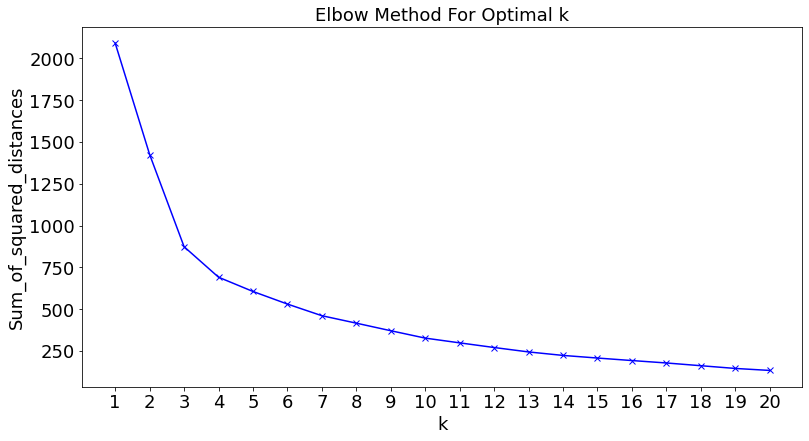

In [19]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k',fontsize=18)
plt.ylabel('Sum_of_squared_distances',fontsize=18)
plt.title('Elbow Method For Optimal k',fontsize=18)
plt.xticks(K,fontsize=18)
plt.yticks(fontsize=18)
# plt.savefig('Elbow.pdf', dpi=300, bbox_inches='tight')

According to the elbow method, k=3 should be chosen. Therefore, I set the number of clusters equal to three and apply the clustering to  the data. I then save the results (cluster labels) in a dataframe (manhattan_merged) together with the other information. I display here the first 5 rows.

In [20]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabel', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Zip_Code'), on='Zip_Code')

manhattan_merged = manhattan_merged.join(manhattan_grouped_freq.set_index('Zip_Code'), on='Zip_Code')

print(manhattan_merged.shape)
manhattan_merged.head() # check the last columns!

(43, 18)


,Neighborhood,Zip_Code,Latitude,Longitude,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,Animal Shelter,Dog Run,Park,Pet Café,Pet Service,Pet Store,Supermarket,Trail,Veterinarian
0,Central Harlem,10026,40.8019,-73.9531,2,Park,Pet Store,Supermarket,Pet Service,0,0,7,0,4,5,4,1,2
1,Central Harlem,10027,40.8116,-73.9550,0,Supermarket,Park,Veterinarian,Trail,0,0,2,0,0,0,5,0,0
2,Central Harlem,10030,40.8183,-73.9426,0,Supermarket,Park,Pet Service,Veterinarian,0,0,2,0,1,0,2,0,0
3,Central Harlem,10037,40.8135,-73.9381,0,Supermarket,Pet Service,Park,Veterinarian,0,0,1,0,1,0,3,0,0
4,Central Harlem,10039,40.8265,-73.9383,0,Supermarket,Pet Service,Park,Veterinarian,0,0,3,0,3,0,3,0,0


I then compute and display the total number of venues in each cateogory and for each cluster.

In [21]:
manhattan_grouped_cluster = manhattan_merged.groupby('ClusterLabel').sum().reset_index()
manhattan_grouped_cluster=manhattan_grouped_cluster.drop(columns=['Zip_Code', 'Latitude','Longitude'])
manhattan_grouped_cluster

,ClusterLabel,Animal Shelter,Dog Run,Park,Pet Café,Pet Service,Pet Store,Supermarket,Trail,Veterinarian
0,0,3,5,48,2,19,19,47,0,8
1,1,6,25,188,0,35,66,28,15,27
2,2,4,7,70,0,90,112,31,7,65


I then plot this informations in a bar chart.

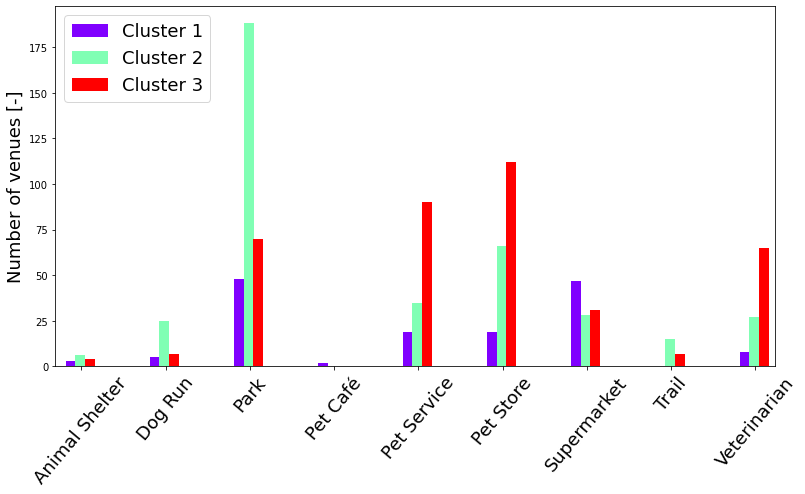

In [22]:
# set color scheme for the clusters
x = np.arange(kclusters)

ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

rainbow = [colors.rgb2hex(i) for i in colors_array]

####
movx=np.linspace(0.,1.25,num=kclusters)
X = np.linspace(0,44,num=len(manhattan_grouped_cluster.columns[1:]))

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])

for i in range(kclusters):
    ax.bar(X+movx[i], manhattan_grouped_cluster.iloc[i,1:], color=rainbow[i], width = 0.65)
plt.xticks(X+0.7, manhattan_grouped_cluster.columns[1:],rotation=50,fontsize=18)
plt.xlim(-1, 46)
plt.ylabel('Number of venues [-]',fontsize=18)
plt.legend(['Cluster 1','Cluster 2','Cluster 3'],loc=2,fontsize=18)
# plt.savefig('ClusterHist.pdf', dpi=300, bbox_inches='tight')

Cluster 2 is mainly characterized by green areas (i.e., dog runs, parks, trails). <br>
Cluster 3 is mainly characterized by various pet services (i.e., pet services, pet stores, veterinarians). <br>
Cluster 1 is mainly characterized by supermarkets but, overall, is not so relevant to answer our business questions.

I also plot the clustered zip code areas on the Manhattan map.

In [23]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Zip_Code'], manhattan_merged['ClusterLabel']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=int(cluster)
    folium.Circle(
        [lat, lon],
        radius=500,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## 4 - Data analysis <a name="dataan"></a>

First, we want to answer the question: Which are the best neighbourhoods to live with a pet dog in Manhattan? <br>
Based on the clustering results shown in the previous section, the best areas are those in cluster 2 and cluster 3. Therefore, now we explore more in detailed each of these two clusters. I compute the toal number of venues (excluding the category "Animal Shelter" since is not relevant to answer the above question) for each zip code areas in each cluster. I then sort them in descending order based on this value. Lets's do it for cluster 2:

In [24]:
cluster_2=manhattan_merged.loc[manhattan_merged['ClusterLabel'] == 1, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]
cluster_2['Total relevant venues']=cluster_2.loc[:,'Dog Run':'Veterinarian'].sum(axis=1)
# allgreen=pd.concat([cluster_2.loc[:, 'Dog Run':'Park'], cluster_2.loc[:, 'Trail']], axis=1)
# cluster_2['Total green pet services']=allgreen.sum(axis=1)
cluster_2=cluster_2.sort_values(by=['Total relevant venues'],ascending=False)
cluster_2.head()

,Zip_Code,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,Animal Shelter,Dog Run,Park,Pet Café,Pet Service,Pet Store,Supermarket,Trail,Veterinarian,Total relevant venues
22,10006,1,Park,Pet Service,Dog Run,Trail,0,3,16,0,4,2,2,2,1,30
20,10004,1,Park,Pet Store,Pet Service,Veterinarian,0,1,15,0,3,7,0,1,2,29
33,10075,1,Park,Pet Store,Pet Service,Veterinarian,0,1,15,0,3,7,0,1,2,29
10,10036,1,Park,Pet Store,Veterinarian,Pet Service,0,4,9,0,4,5,1,0,4,27
21,10005,1,Park,Supermarket,Dog Run,Pet Service,1,3,16,0,2,1,3,1,1,27


and for cluster 3:

In [25]:
cluster_3=manhattan_merged.loc[manhattan_merged['ClusterLabel'] == 2, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]
cluster_3['Total relevant venues']=cluster_3.loc[:,'Dog Run':'Veterinarian'].sum(axis=1)
# allpetserv=pd.concat([cluster_3.loc[:, 'Pet Service':'Pet Store'], cluster_3.loc[:, 'Veterinarian']], axis=1)
# cluster_3['Total pet services']=allpetserv.sum(axis=1)
cluster_3=cluster_3.sort_values(by=['Total relevant venues'],ascending=False)
cluster_3.head()

,Zip_Code,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,Animal Shelter,Dog Run,Park,Pet Café,Pet Service,Pet Store,Supermarket,Trail,Veterinarian,Total relevant venues
6,10011,2,Pet Store,Park,Veterinarian,Pet Service,0,0,10,0,8,10,0,0,9,37
35,10023,2,Pet Store,Park,Pet Service,Veterinarian,0,0,8,0,7,10,4,1,4,34
8,10019,2,Park,Pet Service,Veterinarian,Pet Store,0,1,8,0,7,6,3,1,6,32
9,10020,2,Pet Store,Pet Service,Park,Veterinarian,0,1,6,0,10,11,1,0,3,32
36,10024,2,Pet Store,Pet Service,Park,Veterinarian,1,1,5,0,7,9,4,1,4,31


With these information, I can plot the distribution of the venues for the first 5 zip code areas with the highest total number of venues.

<Figure size 720x360 with 0 Axes>

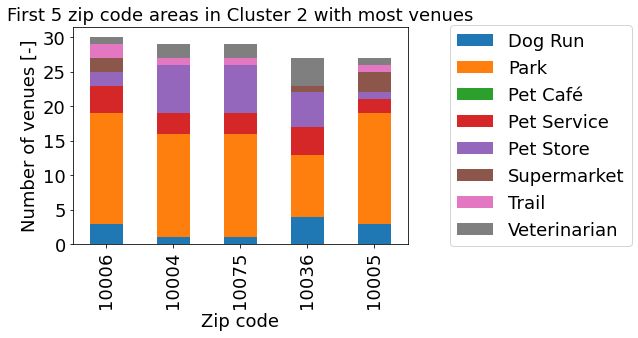

In [26]:
fig = plt.figure(figsize=(10,5))

plotdata=cluster_2.iloc[0:5,7:15]
labels=cluster_2.iloc[0:5,0]
ax=plotdata.plot(kind="bar", stacked=True,fontsize=18)
plt.title("First 5 zip code areas in Cluster 2 with most venues",fontsize=18)
ax.set_xticklabels(labels, rotation=90,fontsize=18)
plt.ylabel("Number of venues [-]",fontsize=18)
plt.xlabel("Zip code",fontsize=18)
plt.legend(bbox_to_anchor=(1.1, 1.05),fontsize=18)
# plt.savefig('DistrCluster2.pdf', dpi=300, bbox_inches='tight')

<Figure size 720x360 with 0 Axes>

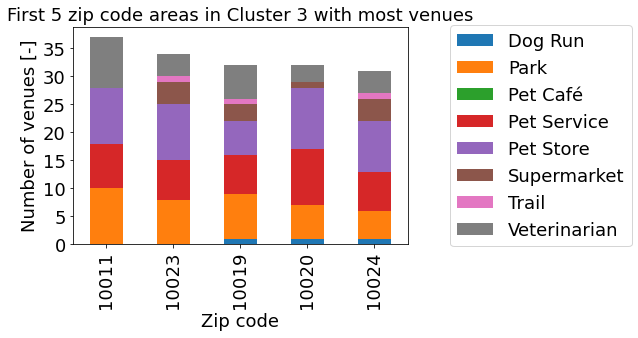

In [27]:
fig = plt.figure(figsize=(10,5))
# ax = fig.add_axes([0,0,1,1])

plotdata=cluster_3.iloc[0:5,7:15]
labels=cluster_3.iloc[0:5,0]
ax=plotdata.plot(kind="bar", stacked=True,legend=None,fontsize=18)
plt.title("First 5 zip code areas in Cluster 3 with most venues",fontsize=18)
ax.set_xticklabels(labels, rotation=90,fontsize=18)
plt.ylabel("Number of venues [-]",fontsize=18)
plt.xlabel("Zip code",fontsize=18)
plt.legend(bbox_to_anchor=(1.1, 1.05),fontsize=18)
# plt.savefig('DistrCluster3.pdf', dpi=300, bbox_inches='tight')

Based on the last two plots, I can select the best zip code area in cluster 2 and 3 in which to live with a furry friends. I will select based on the one with the highest number of venues and a reasonably good distribution of venues in each category. <br>
Zip code area 10006 is the one with the highest number of green areas (dog runs+parks+trails). It has also some pet stores and pet services as well as one veterinarian. This area is suggested for active dogs and dog owners who love to spend most of their time outdoor. <br>
Zip code area 10011 is the one with the highest number of various pet services (pet services+pet stores+veterinarians). It has also some parks but none dog runs. This area is suggested for dog owners who love to have a wide choice of pet services and vet care facilities.. <br>
I now try to answer the second question: Where should an entrepreneur open a food and supply store for dogs in Manhattan?<br>
At this porpuse, I first plot the number of licensed dogs in each zip code area.

43


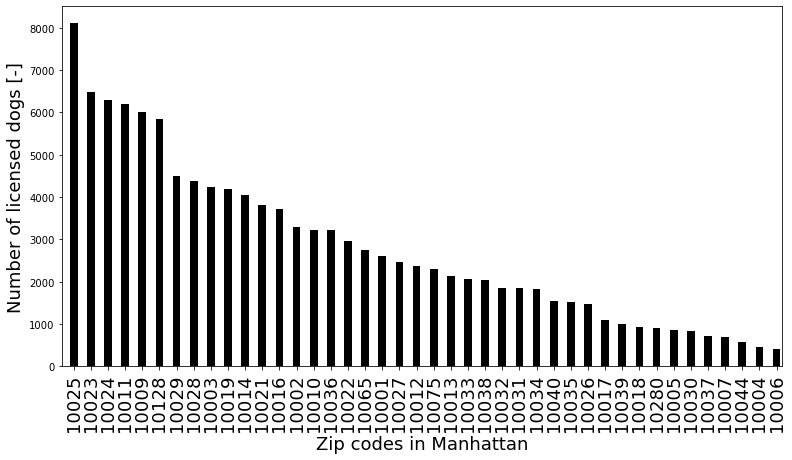

In [28]:
# Plot dog dount vs zip code
xx = np.linspace(0,60,num=len(df_dogcount))
df_dogcount2=df_dogcount.sort_values(by=['Dog count'],ascending=False)
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(xx,df_dogcount2['Dog count'], color='black', width = 0.65)
plt.xticks(xx,df_dogcount2['Zip_Code'],rotation=90,fontsize=18)
plt.xlim(-1, 59)
plt.ylabel('Number of licensed dogs [-]',fontsize=18)
plt.xlabel('Zip codes in Manhattan',fontsize=18)
print(len(df_dogcount2))
# plt.savefig('DogZip.pdf', dpi=300, bbox_inches='tight')

And I plot also a colormap in which the polygons defining each zip code area are colored based on the number of licensed dogs.


In [29]:
df_nycpolygons=df_dogcount2.merge(df_nycpolygons, how='inner', left_on=['Zip_Code'], right_on=['Zip_Code'])

from branca.colormap import linear
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10.5)

dog_count_colormap = linear.YlGnBu_09.scale(min(df_nycpolygons['Dog count']),
                                            max(df_nycpolygons['Dog count']))

for index, row in df_nycpolygons.iterrows():
    index2=row['Dog count']
    folium.GeoJson(
        row['Polygon coordinates'],
        name='geojson',
        style_function=lambda x, index2=index2:{
            'fillColor': dog_count_colormap(index2), 
            'color': 'black', 
            'weight': 1.5, 
            'fillOpacity': 1 },
    ).add_to(map_clusters2)
    
dog_count_colormap.caption = 'Number of licensed dogs [-]'  
dog_count_colormap.add_to(map_clusters2)

map_clusters2


Now that I have an idea on how the dog's population is distributed in Manhattan, I perform the following steps:<br>
step1 - I compute the total number of pet stores and supermarkets in each zip code area <br>
step2 - I compute the ratio of the total number of pet stores and supermarkets over the number of dogs in each zip code area.

In [30]:
manhattan_grouped2 = df2.merge(manhattan_merged, how='inner', left_on=['Zip_Code'], right_on=['Zip_Code'])
petfood=pd.concat([manhattan_grouped2.loc[:, 'Pet Store'], manhattan_grouped2.loc[:, 'Supermarket']], axis=1)
manhattan_grouped2['Total pet food/supply']=petfood.sum(axis=1)

manhattan_grouped2['Pet stores/Dogs']=manhattan_grouped2['Total pet food/supply']/manhattan_grouped2['Dog count']
manhattan_grouped2=manhattan_grouped2.sort_values(by=['Pet stores/Dogs'],ascending=True)
manhattan_grouped2.head()

,Zip_Code,Dog count,Neighborhood,Latitude,Longitude,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,Animal Shelter,Dog Run,Park,Pet Café,Pet Service,Pet Store,Supermarket,Trail,Veterinarian,Total pet food/supply,Pet stores/Dogs
35,10038,2030,Lower Manhattan,40.7101,-74.0013,1,Park,Veterinarian,Dog Run,Trail,0,2,11,0,1,1,1,1,2,2,0.000985
22,10025,8105,Upper West Side,40.7975,-73.9683,2,Pet Store,Pet Service,Park,Veterinarian,0,0,6,0,6,6,4,0,4,10,0.001234
1,10002,3299,Lower East Side,40.7152,-73.9877,1,Park,Supermarket,Pet Store,Trail,0,0,10,0,1,2,3,1,0,5,0.001516
13,10016,3717,"Gramercy Park, Murray Hill",40.7443,-73.9781,1,Park,Pet Store,Veterinarian,Pet Service,0,2,7,0,2,5,1,1,3,6,0.001614
9,10011,6194,"Chelsea, Clinton",40.7402,-73.9996,2,Pet Store,Park,Veterinarian,Pet Service,0,0,10,0,8,10,0,0,9,10,0.001614


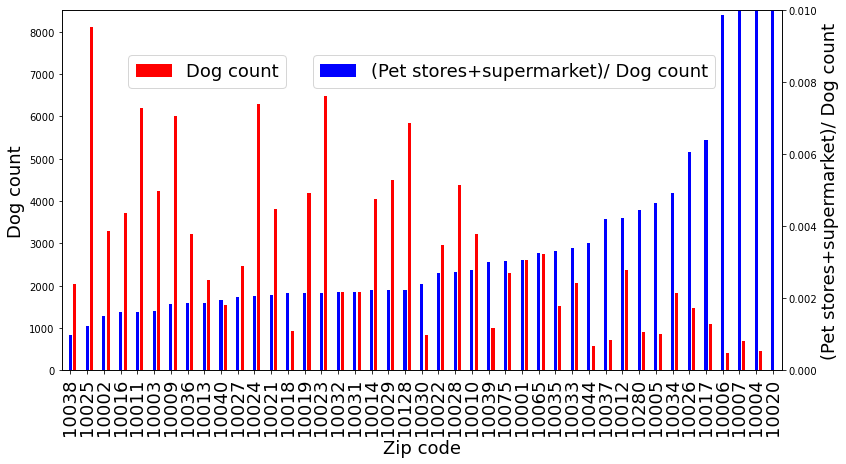

In [31]:
# # Plot dog dount vs zip code
xx = np.linspace(0,60,num=len(manhattan_grouped2))

####

movx=np.linspace(0.,1.25,num=2)
X = np.linspace(0,80,num=len(manhattan_grouped2))

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

ax2.bar(X, manhattan_grouped2.iloc[0:,20], color='blue', width = 0.35)
ax.bar(X+0.5, manhattan_grouped2.iloc[0:,1], color='red', width = 0.35)
# plt.xticks(X+0.7, manhattan_grouped.iloc[0:,1],rotation=90,fontsize=18)
ax2.set_ylim(0, 0.01)
ax2.set_xlim(-1, 81)
ax2.set_ylabel('(Pet stores+supermarket)/ Dog count',fontsize=18)
ax.set_ylabel('Dog count',fontsize=18)
ax.set_xlabel('Zip code',fontsize=18)
plt.xticks(X,manhattan_grouped2['Zip_Code'],rotation=90,fontsize=18)
ax2.legend(['(Pet stores+supermarket)/ Dog count'],loc=0, bbox_to_anchor=(0.92,0.9),fontsize=18)
ax.legend(['Dog count'],loc=0, bbox_to_anchor=(0.08,0.9),fontsize=18)
ax.set_xticklabels(manhattan_grouped2['Zip_Code'], rotation=90,fontsize=18)
plt.savefig('PetStoreRatio.pdf', dpi=300, bbox_inches='tight')

The 10038 zip code area is the one with the smallest number of pet stores and supermarket per number of licensed dogs. Therefore, it might be a successful area in which to open a supply and food store for dogs. Also the 10025 zip code area might be a good spot. Indeed, it is the zip code where most of the dogs lives but the ratio is still quite low. <br>
A point to be highlighted is that the dogs in animal shelters are not licensed therefore they are not included in the dog count. Therefore, I have looked for the zip code where there are the highest number of animal shelters. This is the zip code area 10013 where there are 4 animal shelters and have a quite low ratio. I plot on the map these zip code areas of interested in order to provide a final answer to the business questions.

In [32]:
zip10038=manhattan_grouped2.loc[manhattan_grouped2['Zip_Code'] == 10038]
zip10025=manhattan_grouped2.loc[manhattan_grouped2['Zip_Code'] == 10025]
zip10011=manhattan_grouped2.loc[manhattan_grouped2['Zip_Code'] == 10011]
zip10006=manhattan_grouped2.loc[manhattan_grouped2['Zip_Code'] == 10006]
zip10013=manhattan_grouped2.loc[manhattan_grouped2['Zip_Code'] == 10013]

In [33]:
# create map
map_clusters_final = folium.Map(location=[latitude, longitude], zoom_start=11)

group0 = folium.FeatureGroup(name='<span style=\\"color: red;\\">Best for various pet services (zip code=10011)</span>')
for index, row in zip10011.iterrows():
    folium.Circle(
        [row['Latitude'], row['Longitude']],
        radius=500,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(group0)
group0.add_to(map_clusters_final)

group1 = folium.FeatureGroup(name='<span style=\\"color: green;\\">Best for outdoor activities with your dog (zip code=10006)</span>')
for index, row in zip10006.iterrows():
    folium.Circle(
        [row['Latitude'], row['Longitude']],
        radius=500,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7).add_to(group1)
group1.add_to(map_clusters_final)

group2 = folium.FeatureGroup(name='<span style=\\"color: blue;\\">Best for opening a pet store (zip code=10038)</span>')
for index, row in zip10038.iterrows():
    folium.Circle(
        [row['Latitude'], row['Longitude']],
        radius=500,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(group2)
group2.add_to(map_clusters_final)

group3 = folium.FeatureGroup(name='<span style=\\"color: orange;\\">Where most of the dogs live (zip code=10025)</span>')
for index, row in zip10025.iterrows():
    folium.Circle(
        [row['Latitude'], row['Longitude']],
        radius=500,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7).add_to(group3)
group3.add_to(map_clusters_final)

group4 = folium.FeatureGroup(name='<span style=\\"color: black;\\">Where most animal shelters are located (zip code=10013)</span>')
for index, row in zip10013.iterrows():
    folium.Circle(
        [row['Latitude'], row['Longitude']],
        radius=500,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(group4)
group4.add_to(map_clusters_final)

folium.map.LayerControl('topright', collapsed=False).add_to(map_clusters_final)
    
map_clusters_final

To conclude:<br>
1- Zip code area 10006 is the one with highest number of green areas (dog runs+parks+trails). This area is suggested for active dogs and dog owners who love to spend most of their time outdoor.
2- Zip code area 10011 is the one with highest number of various pet services (pet services+pet stores+veterinarians). This area is suggested for dog owners who love to have a wide choice of pet serivices and vet care facilities.<br>
3- Zip code area 10038 is the one with the smallest number of pet stores and supermarket per number of licensed dogs. Moreover, it is next to the zip code area 10013 where there are the highest number of animal shelters that might need a lot of food and supplies.  Zip code area 10038 is also next to the zip code area 10006 where most of the green areas are located and likely very frequented by dog owners. Therefore, zip code area 10038 might be the best spot in Manhattan in which to open a food and supply store for dogs.